# Importação dos dados

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cardiotocography = fetch_ucirepo(id=193) 
  
# data (as pandas dataframes) 
X = cardiotocography.data.features 
y = cardiotocography.data.targets 
  
# metadata 
print(cardiotocography.metadata) 
  
# variable information 
print(cardiotocography.variables) 


{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.concat([X, y], axis=1)

df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1


# Separação dos conjuntos

In [5]:
X = df.drop(columns=['NSP'])
y = df['NSP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Definição de funções e parâmetros

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score, confusion_matrix, fbeta_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_best_model(grid_search, X_test, y_test):
    # Melhor modelo do grid search
    best_model = grid_search.best_estimator_

    # Previsões do modelo
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    test_metrics = {}
    
    # Cálculo das métricas
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, average='weighted', beta=2)

    # Criação dos dummies pois a curva roc usa dados binários
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovo', average='weighted')
    
    # Exibindo retornos
    test_metrics['F1'] = f1
    test_metrics['ACURACIA'] = accuracy
    test_metrics['Fbeta'] = fbeta
    test_metrics['ROC_AUC'] = roc_auc

    print(f"F1 no conjunto de teste: {f1}")
    print(f"ACURACIA no conjunto de teste: {accuracy}")
    print(f"Fbeta no conjunto de teste: {fbeta}")
    print(f"Área sob a curva ROC no conjunto de teste: {roc_auc}")

    print('Matriz de confusão:')
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
    
    plt.figure(figsize=(8, 6))  # Ajuste o tamanho da figura
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])
    plt.title('Matriz de Confusão')
    plt.tight_layout()  # Ajuste o layout para evitar truncamento
    plt.show()
    
    print('Area sob a curva ROC por classe:')
    
    plt.figure(figsize=(8, 6))  # Ajuste o tamanho da figura
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, marker='.', label=f'NSP {i + 1}')

    plt.xlabel('Falso positivo')
    plt.ylabel('Positivos')
    plt.title('Curva ROC para cada NSP')
    plt.legend(loc='best')
    plt.tight_layout()  # Ajuste o layout para evitar truncamento
    plt.show()

    return test_metrics

In [9]:
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# F-beta
fbeta_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

scores = {'ROC_AUC': 'roc_auc_ovo_weighted', 
          'Fbeta': fbeta_scorer, 
          'F1': 'f1_weighted', 
          'ACURACIA': 'accuracy'}


experiment_mapping = {
    'KNN': 'KNN Experiments',
    'DecisionTree': 'Decision Tree Experiments',
    'MLP': 'MLP Experiments',
    'NaiveBayes': 'Naive Bayes Experiments'
}

classifiers = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 8, 10, 12, 15, 18, 20, 21, 22, 25],
            'weights': ['uniform', 'distance']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30, 40, 50]
        }
    },
    'MLP': {
        'model': MLPClassifier(max_iter=1000),
        'param_grid': {
            'hidden_layer_sizes': [(50,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'param_grid': {
            'var_smoothing': [1e-09, 1e-08, 1e-07]
        }
    }
}

# Modelos

Para cada modelos vamos gerar o melhor conjunto de hiperparâmetros considerando cada métrica.

2024/08/10 18:45:14 INFO mlflow.tracking.fluent: Experiment with name 'KNN Experiments' does not exist. Creating a new experiment.


=== Treinando KNN ===
Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9529277167344545
F1 no conjunto de teste: 0.9087212979356062
ACURACIA no conjunto de teste: 0.9130434782608695
Fbeta no conjunto de teste: 0.9108447553585268
Área sob a curva ROC no conjunto de teste: 0.9570060647903952
Matriz de confusão:


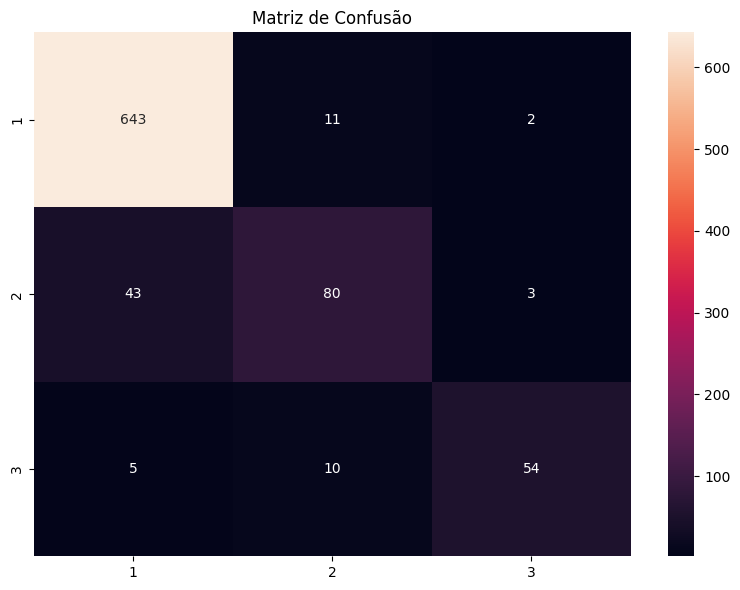

Area sob a curva ROC por classe:


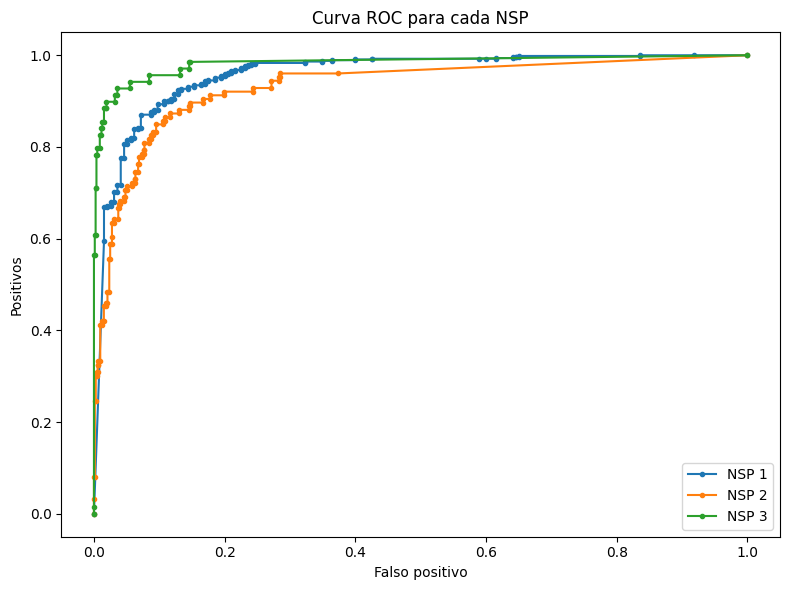

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor Fbeta no conjunto de treinamento: 0.9127889290273797
F1 no conjunto de teste: 0.9234555022075417
ACURACIA no conjunto de teste: 0.9259694477085781
Fbeta no conjunto de teste: 0.9247296257851674
Área sob a curva ROC no conjunto de teste: 0.9235126237626651
Matriz de confusão:


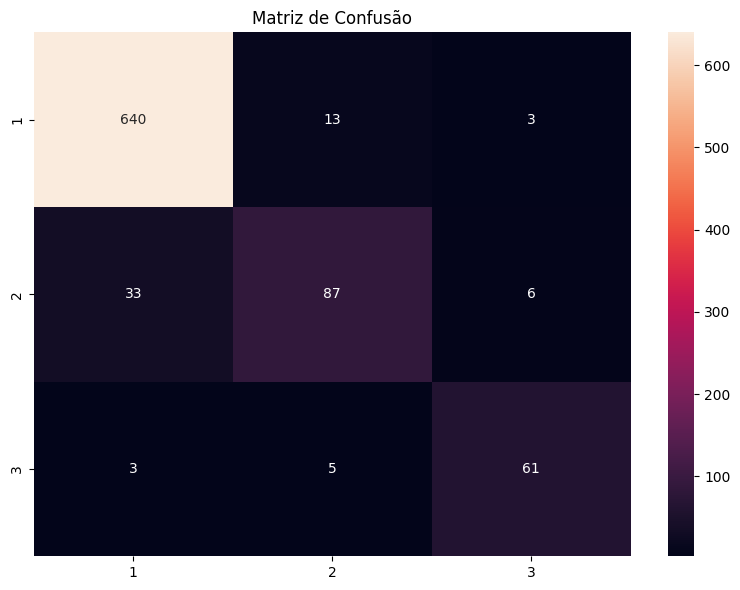

Area sob a curva ROC por classe:


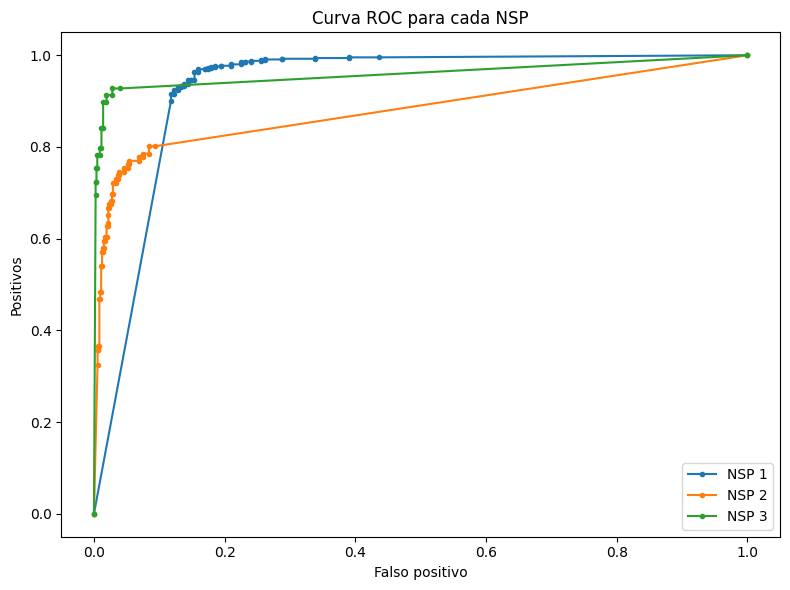

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor F1 no conjunto de treinamento: 0.9111074530307783
F1 no conjunto de teste: 0.9234555022075417
ACURACIA no conjunto de teste: 0.9259694477085781
Fbeta no conjunto de teste: 0.9247296257851674
Área sob a curva ROC no conjunto de teste: 0.9235126237626651
Matriz de confusão:


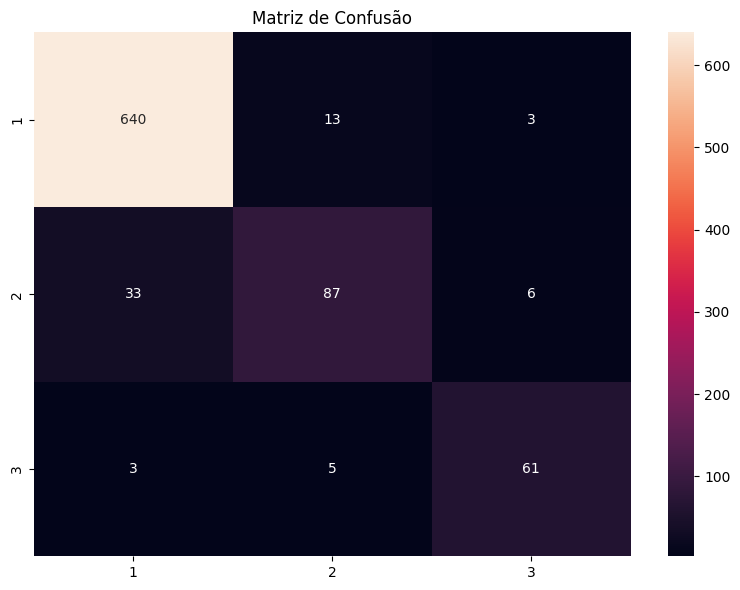

Area sob a curva ROC por classe:


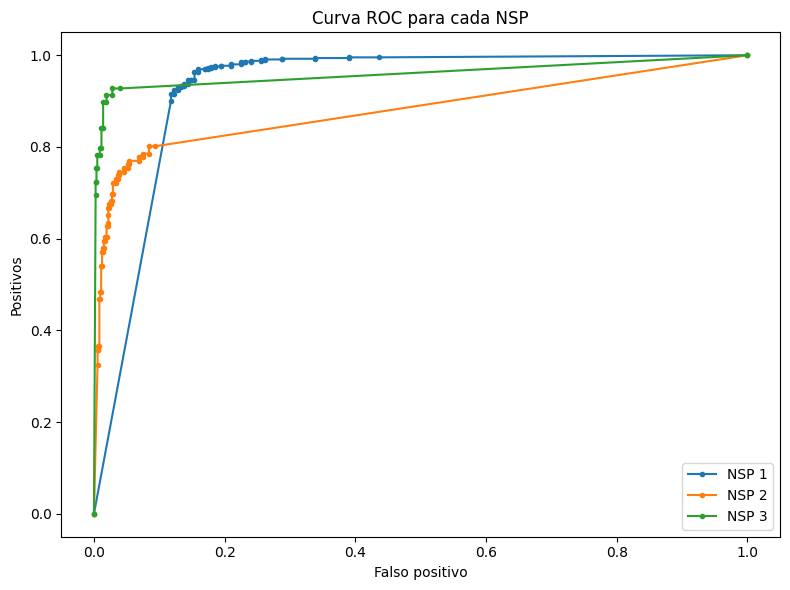

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor ACURACIA no conjunto de treinamento: 0.9145546259842521
F1 no conjunto de teste: 0.9234555022075417
ACURACIA no conjunto de teste: 0.9259694477085781
Fbeta no conjunto de teste: 0.9247296257851674
Área sob a curva ROC no conjunto de teste: 0.9235126237626651
Matriz de confusão:


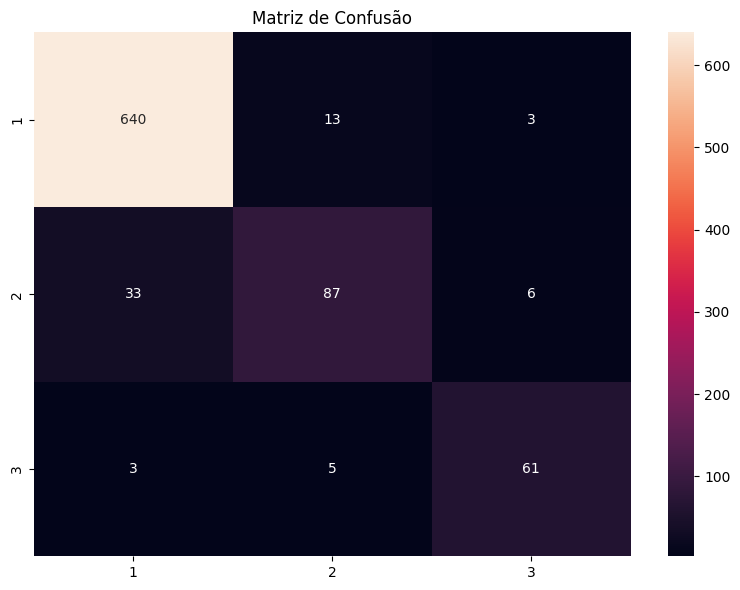

Area sob a curva ROC por classe:


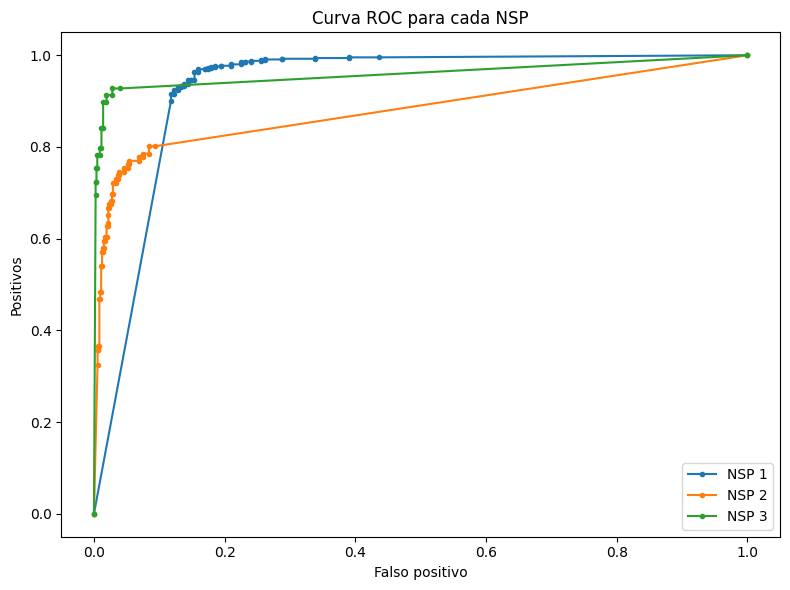

2024/08/10 18:45:43 INFO mlflow.tracking.fluent: Experiment with name 'Decision Tree Experiments' does not exist. Creating a new experiment.


=== Treinando DecisionTree ===
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9787987200201191
F1 no conjunto de teste: 0.9845982354283412
ACURACIA no conjunto de teste: 0.9847238542890717
Fbeta no conjunto de teste: 0.9846575914807005
Área sob a curva ROC no conjunto de teste: 0.974095634095634
Matriz de confusão:


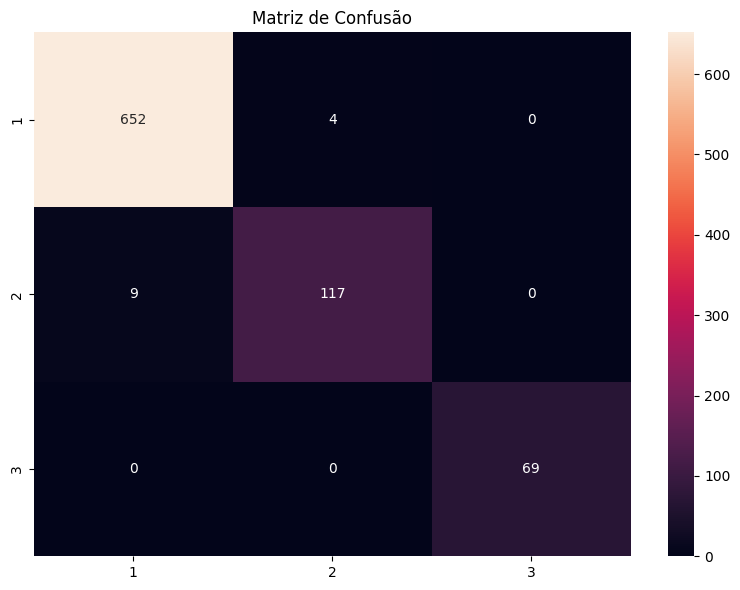

Area sob a curva ROC por classe:


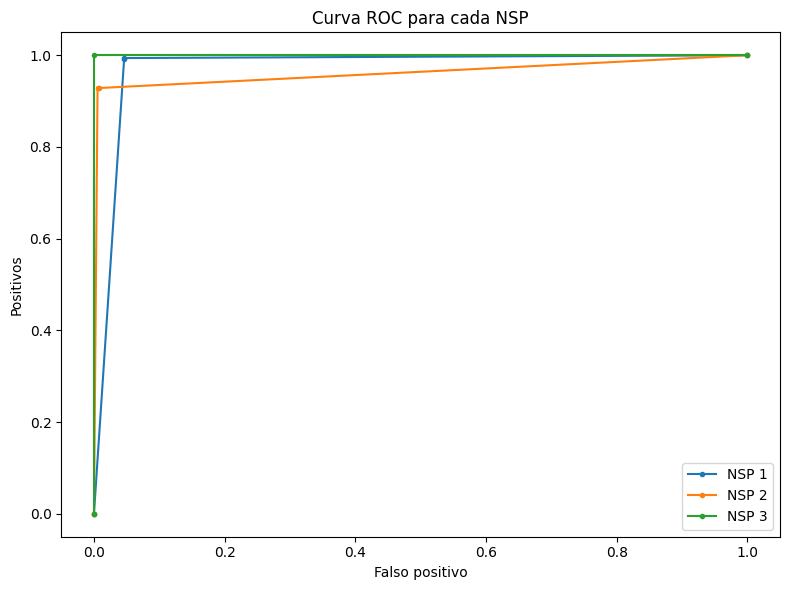

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor Fbeta no conjunto de treinamento: 0.9856825185651582
F1 no conjunto de teste: 0.9809473440264603
ACURACIA no conjunto de teste: 0.981198589894242
Fbeta no conjunto de teste: 0.98105741862075
Área sob a curva ROC no conjunto de teste: 0.9663345042655387
Matriz de confusão:


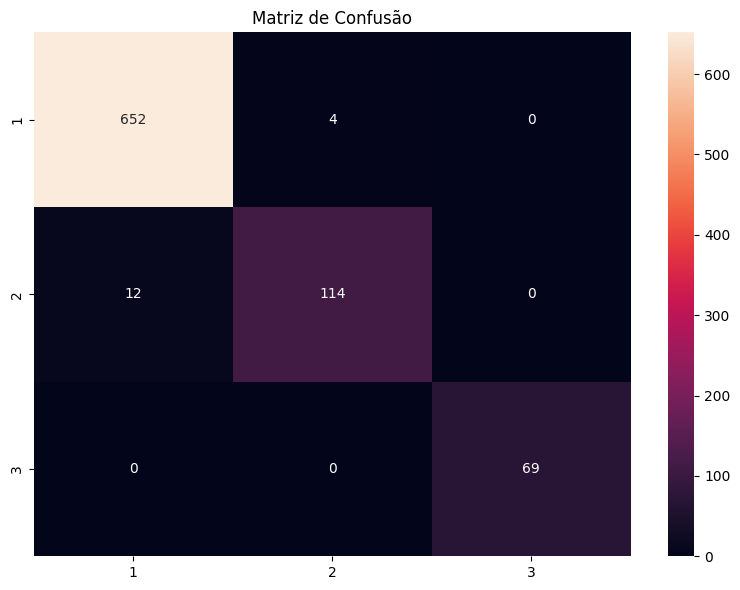

Area sob a curva ROC por classe:


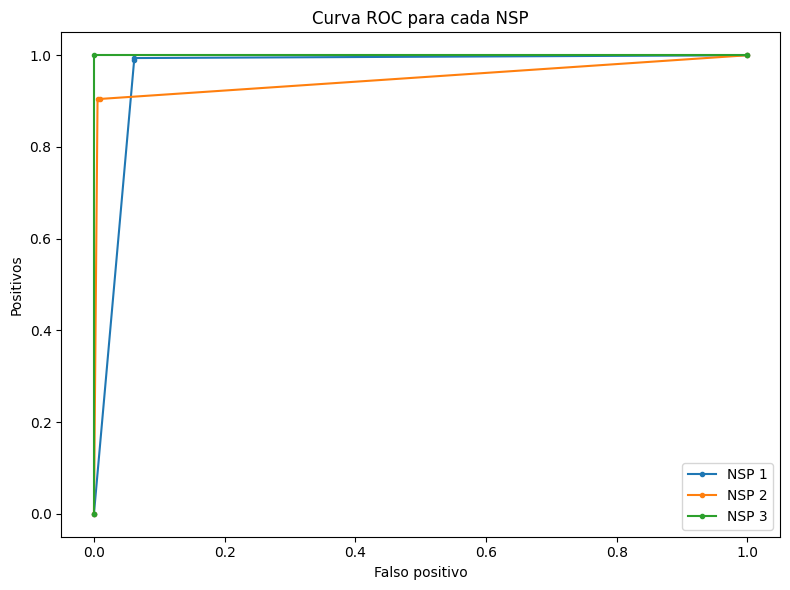

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor F1 no conjunto de treinamento: 0.9842020206024727
F1 no conjunto de teste: 0.9823452780629669
ACURACIA no conjunto de teste: 0.982373678025852
Fbeta no conjunto de teste: 0.9823616848613168
Área sob a curva ROC no conjunto de teste: 0.9771969316796902
Matriz de confusão:


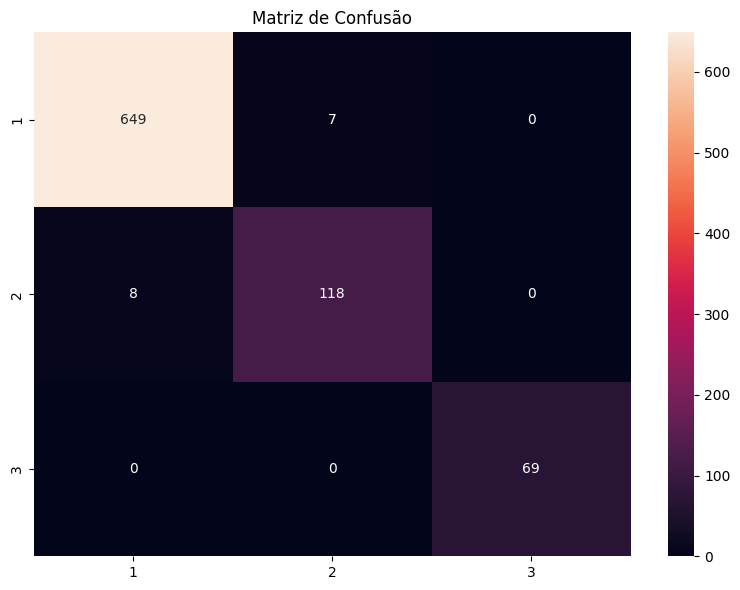

Area sob a curva ROC por classe:


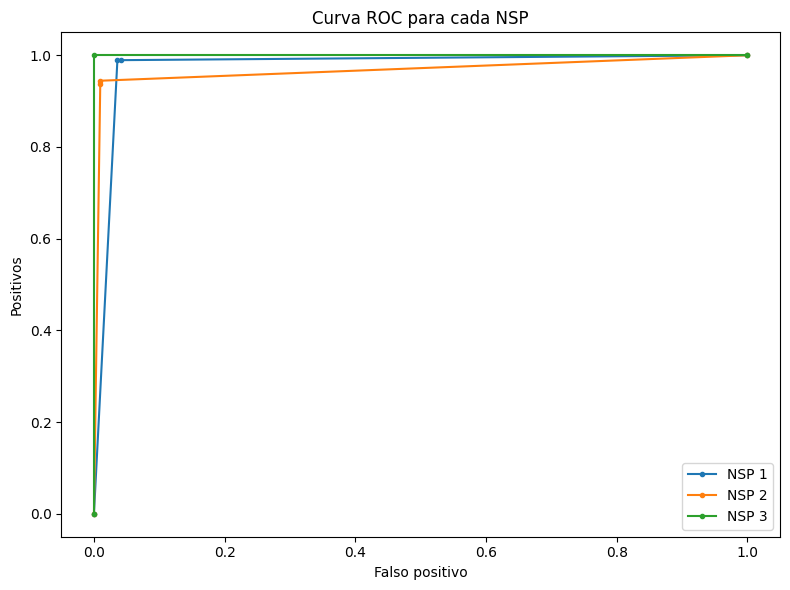

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor ACURACIA no conjunto de treinamento: 0.9850947342519685
F1 no conjunto de teste: 0.9822287331865476
ACURACIA no conjunto de teste: 0.982373678025852
Fbeta no conjunto de teste: 0.9822998030788382
Área sob a curva ROC no conjunto de teste: 0.9734174492795182
Matriz de confusão:


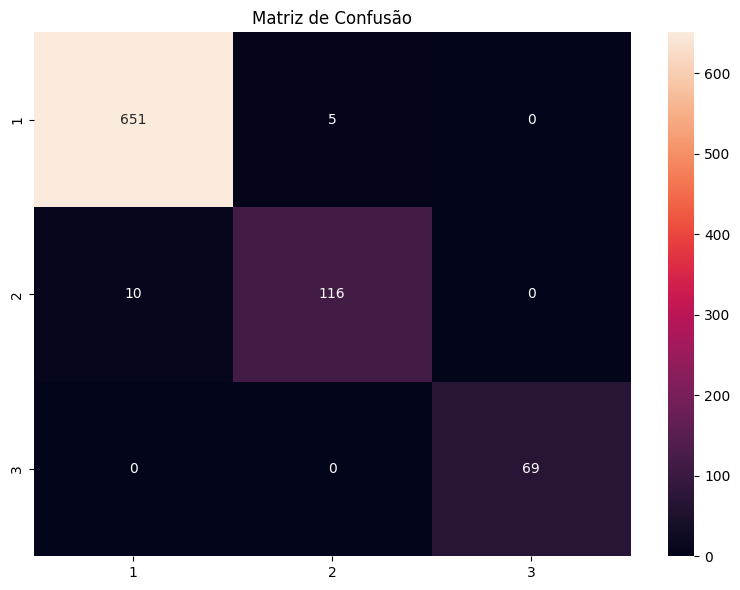

Area sob a curva ROC por classe:


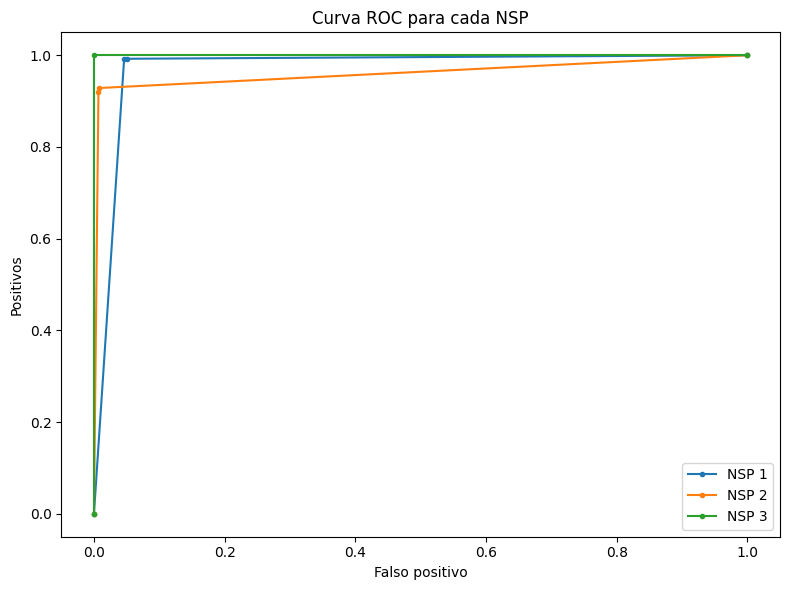

2024/08/10 18:46:02 INFO mlflow.tracking.fluent: Experiment with name 'MLP Experiments' does not exist. Creating a new experiment.


=== Treinando MLP ===
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor ROC_AUC no conjunto de treinamento: 0.986726807164907
F1 no conjunto de teste: 0.9601038058483667
ACURACIA no conjunto de teste: 0.9612220916568742
Fbeta no conjunto de teste: 0.9606188001628202
Área sob a curva ROC no conjunto de teste: 0.9849449151247868
Matriz de confusão:


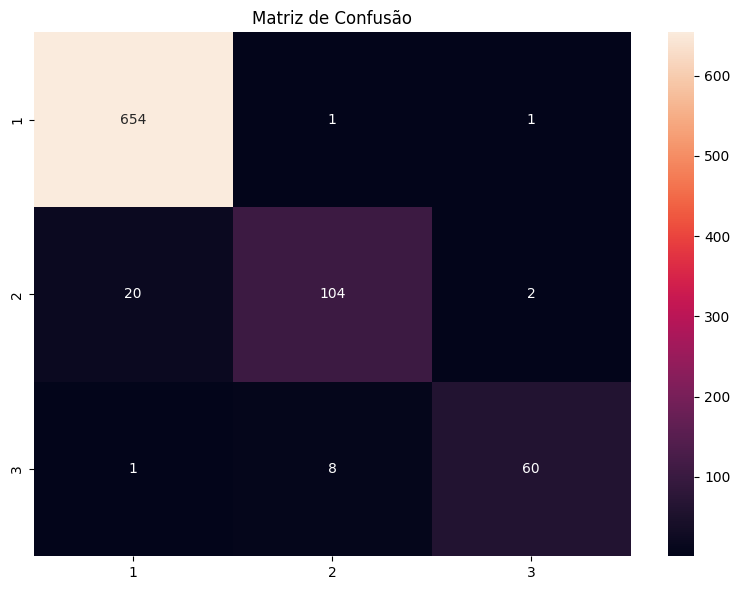

Area sob a curva ROC por classe:


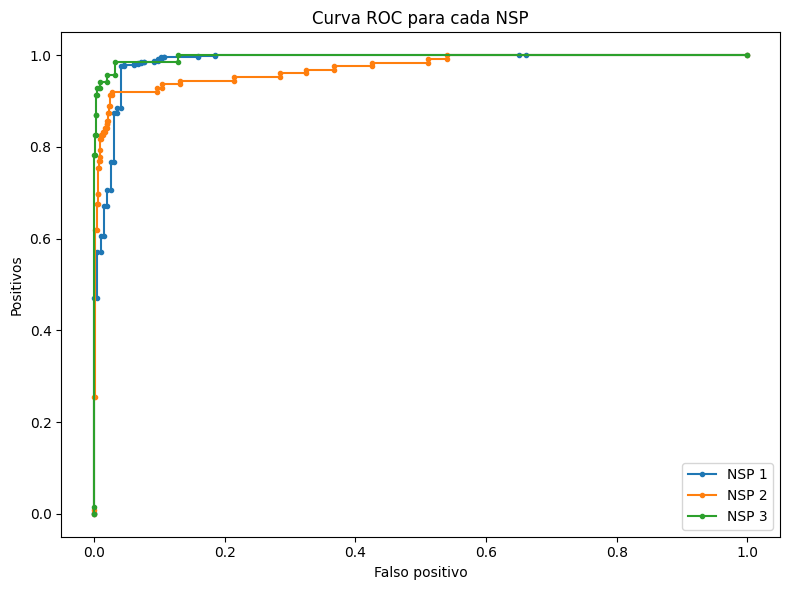

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor Fbeta no conjunto de treinamento: 0.9570413003829916
F1 no conjunto de teste: 0.9517663188696449
ACURACIA no conjunto de teste: 0.9529964747356052
Fbeta no conjunto de teste: 0.9523817106964199
Área sob a curva ROC no conjunto de teste: 0.9821685964074872
Matriz de confusão:


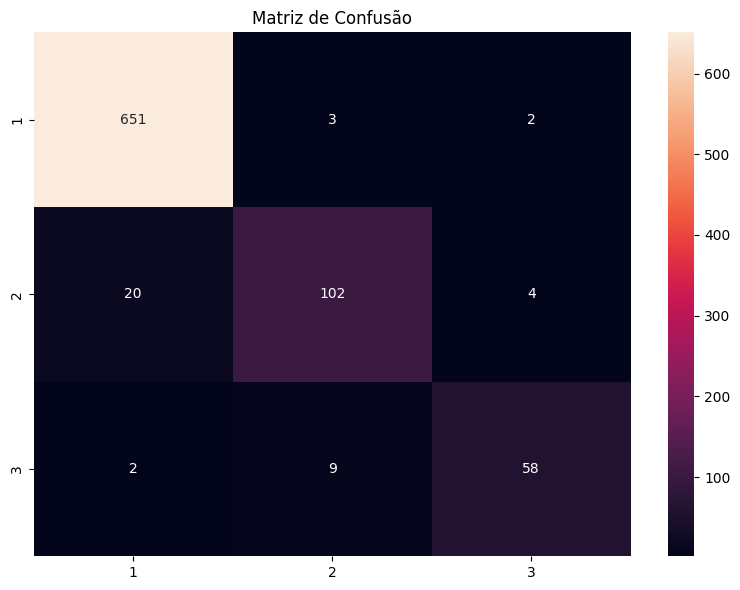

Area sob a curva ROC por classe:


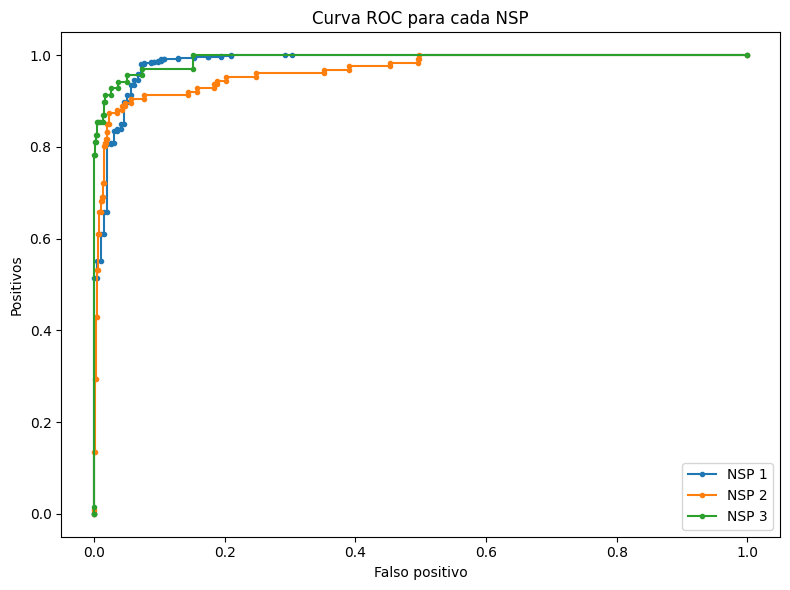

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor F1 no conjunto de treinamento: 0.9576704690348263
F1 no conjunto de teste: 0.9488927201762402
ACURACIA no conjunto de teste: 0.9506462984723855
Fbeta no conjunto de teste: 0.9496950919470586
Área sob a curva ROC no conjunto de teste: 0.9848315461349353
Matriz de confusão:


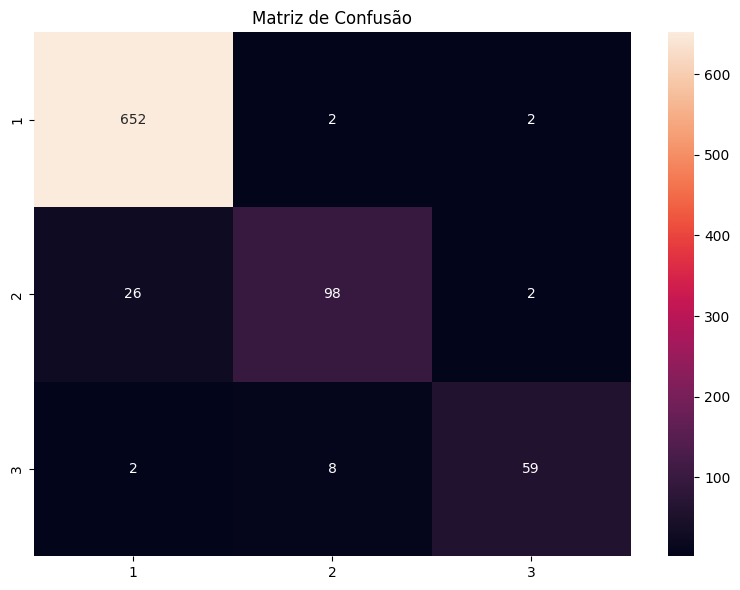

Area sob a curva ROC por classe:


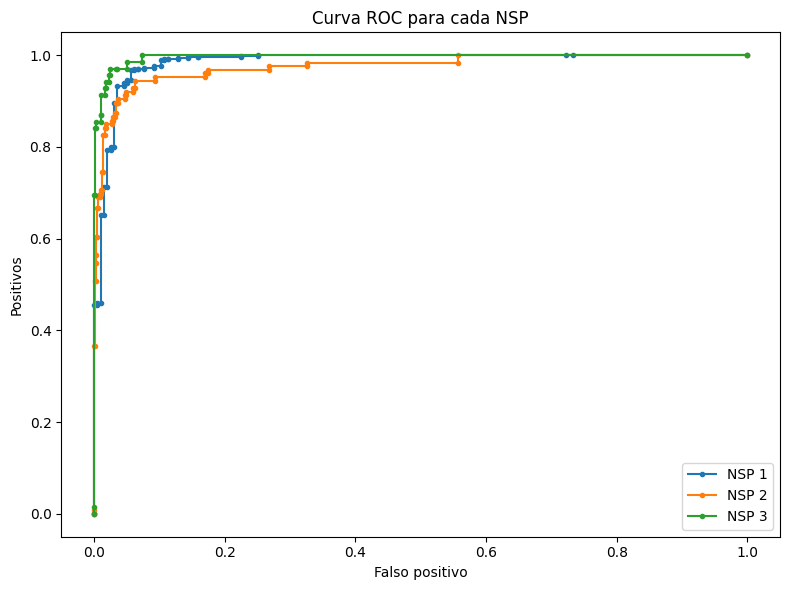

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor ACURACIA no conjunto de treinamento: 0.954521407480315
F1 no conjunto de teste: 0.9540806669601188
ACURACIA no conjunto de teste: 0.9553466509988249
Fbeta no conjunto de teste: 0.9546865794141148
Área sob a curva ROC no conjunto de teste: 0.9822574658404056
Matriz de confusão:


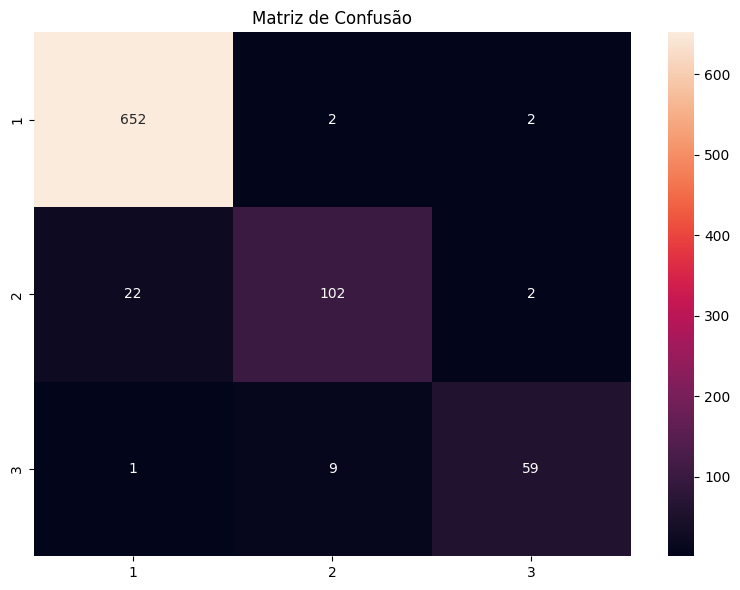

Area sob a curva ROC por classe:


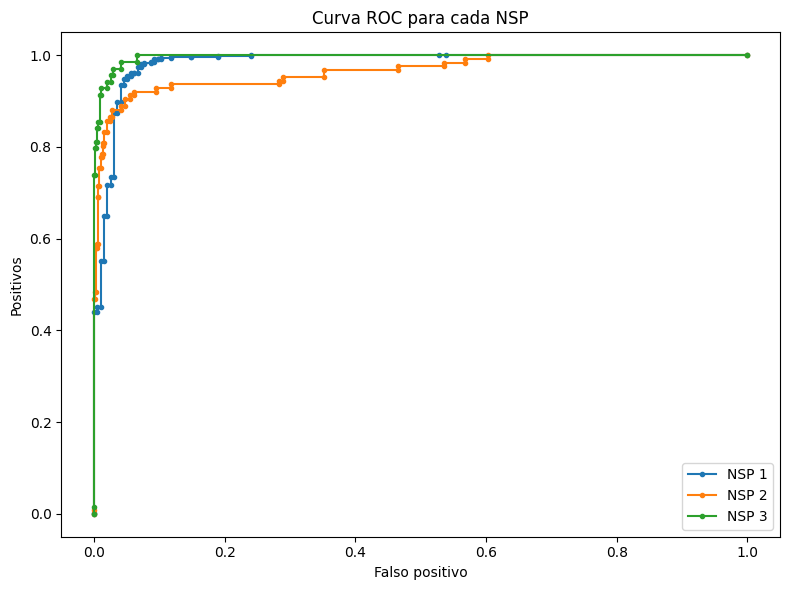

2024/08/10 18:55:41 INFO mlflow.tracking.fluent: Experiment with name 'Naive Bayes Experiments' does not exist. Creating a new experiment.


=== Treinando NaiveBayes ===
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9522113929970661
F1 no conjunto de teste: 0.8843940550381334
ACURACIA no conjunto de teste: 0.8777908343125734
Fbeta no conjunto de teste: 0.8792008138306723
Área sob a curva ROC no conjunto de teste: 0.9587840741007381
Matriz de confusão:


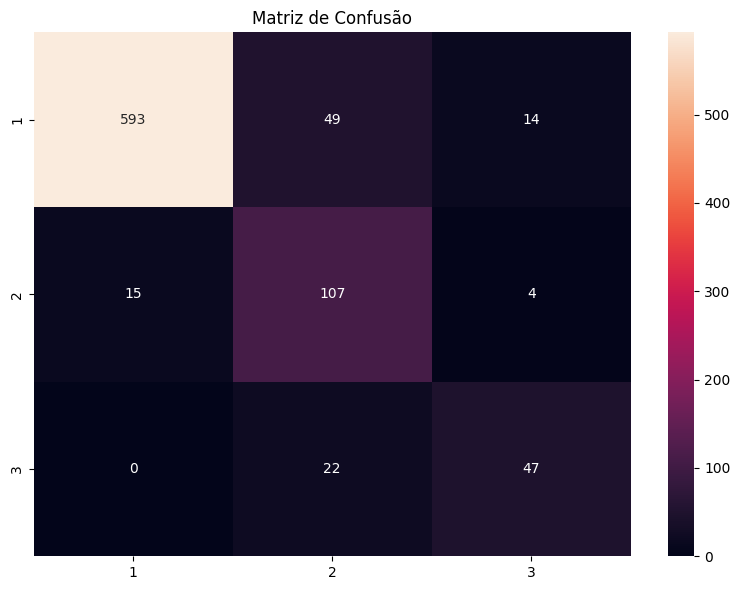

Area sob a curva ROC por classe:


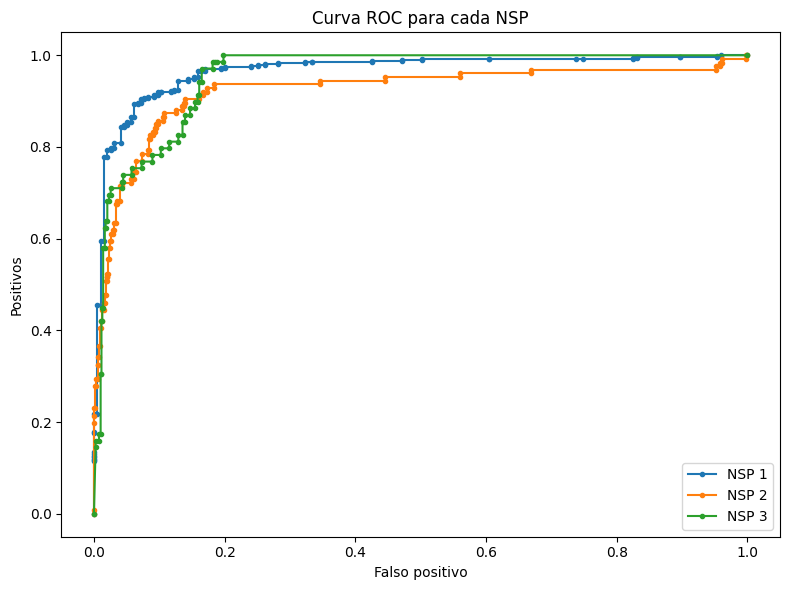

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor Fbeta no conjunto de treinamento: 0.8978326375078792
F1 no conjunto de teste: 0.8894970956139593
ACURACIA no conjunto de teste: 0.8860164512338425
Fbeta no conjunto de teste: 0.8870439595405257
Área sob a curva ROC no conjunto de teste: 0.9517591502806056
Matriz de confusão:


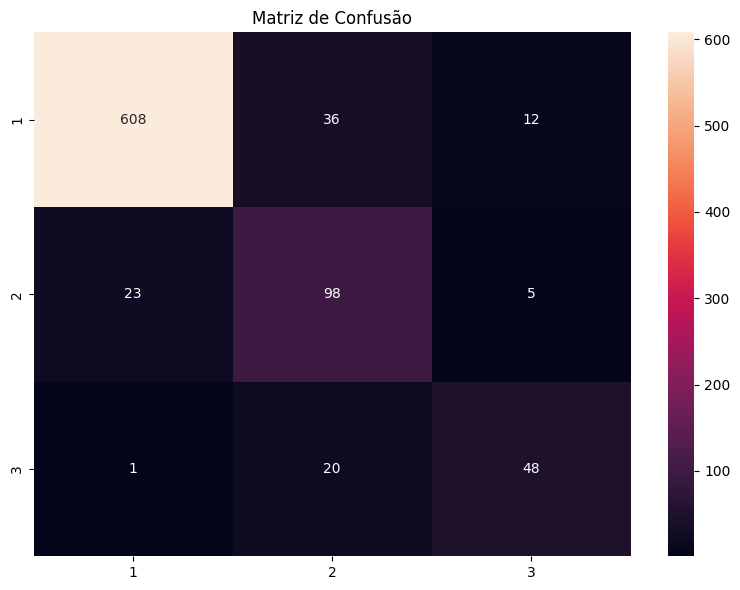

Area sob a curva ROC por classe:


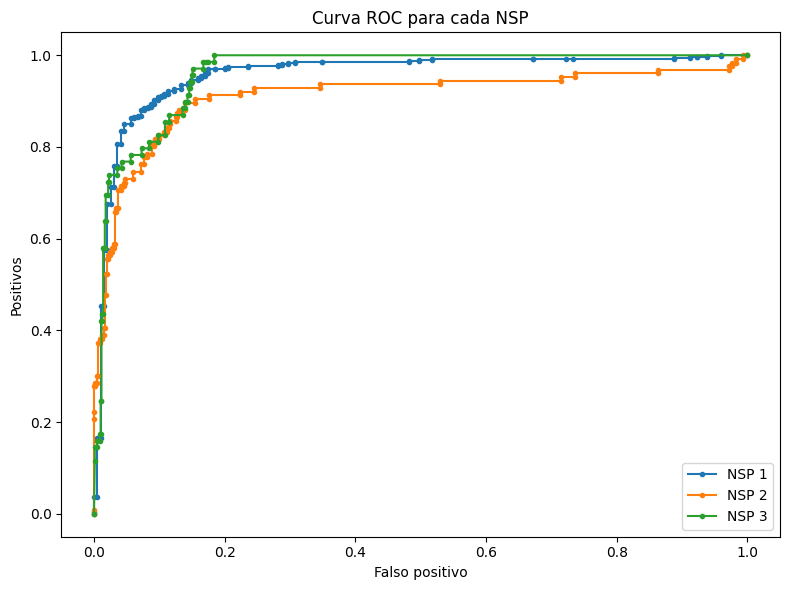

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor F1 no conjunto de treinamento: 0.9004553228518182
F1 no conjunto de teste: 0.8894970956139593
ACURACIA no conjunto de teste: 0.8860164512338425
Fbeta no conjunto de teste: 0.8870439595405257
Área sob a curva ROC no conjunto de teste: 0.9517591502806056
Matriz de confusão:


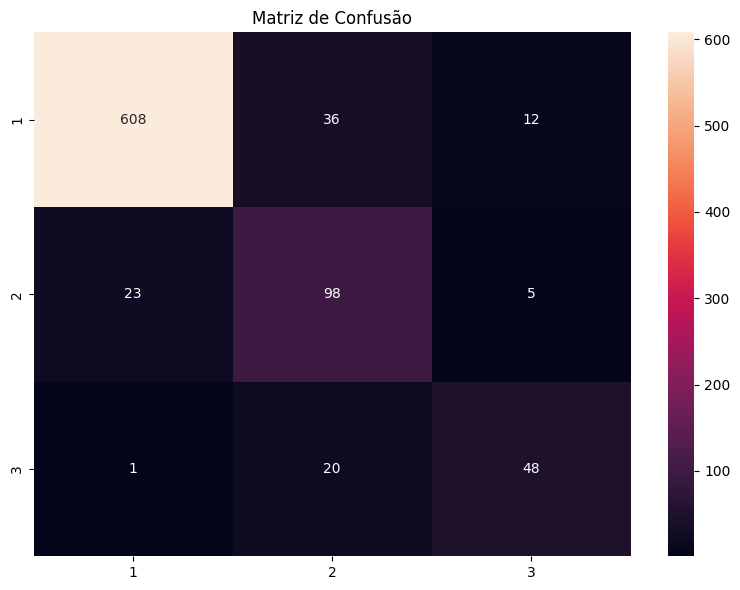

Area sob a curva ROC por classe:


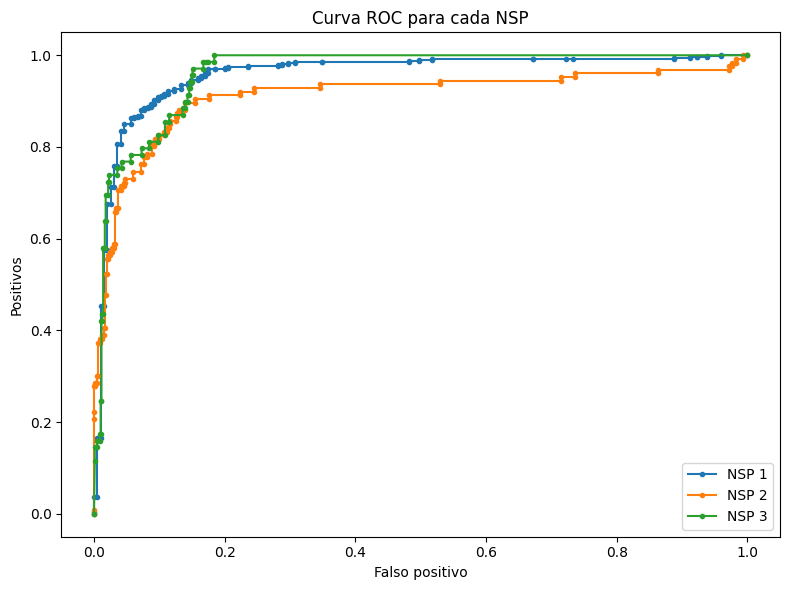

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor ACURACIA no conjunto de treinamento: 0.8980253444881889
F1 no conjunto de teste: 0.8894970956139593
ACURACIA no conjunto de teste: 0.8860164512338425
Fbeta no conjunto de teste: 0.8870439595405257
Área sob a curva ROC no conjunto de teste: 0.9517591502806056
Matriz de confusão:


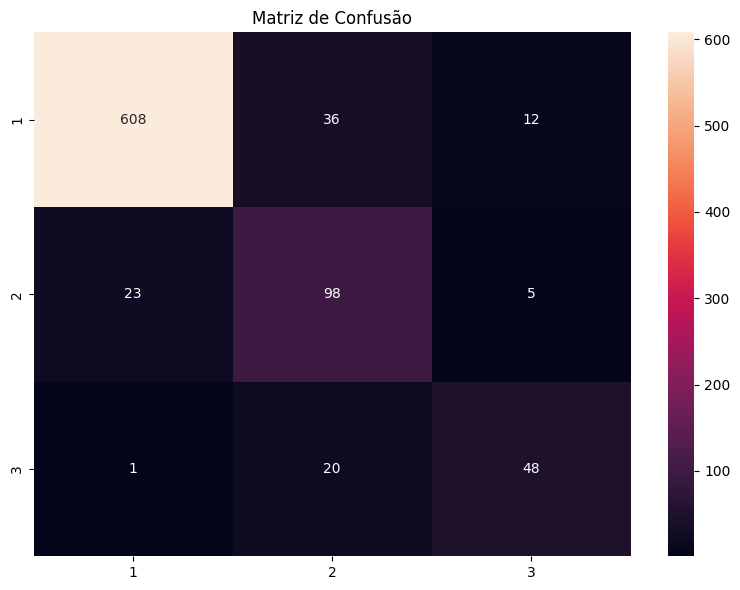

Area sob a curva ROC por classe:


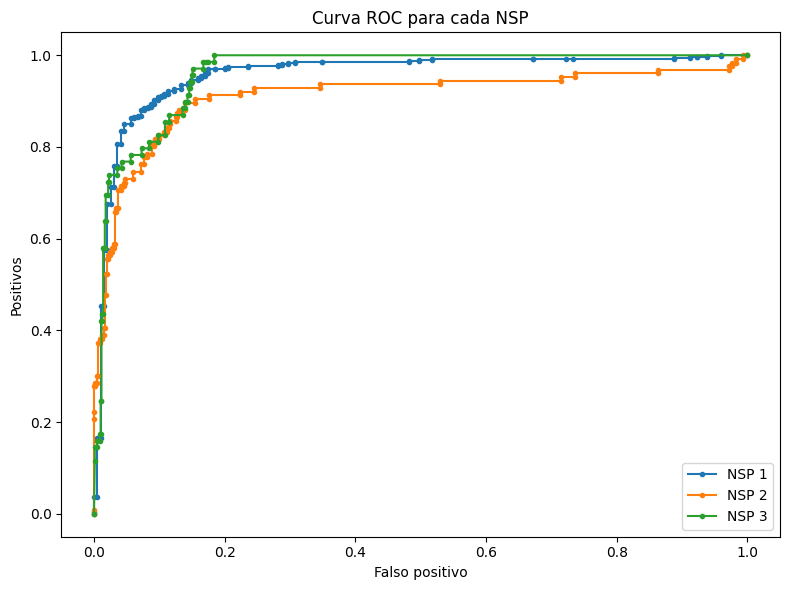

In [13]:
from sklearn.model_selection import GridSearchCV

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

for clf_name, clf_info in classifiers.items():
    # experimento MLflow
    mlflow.set_experiment(experiment_mapping[clf_name])
    
    print(f"=== Treinando {clf_name} ===")
    
    for score_name, score_metric in scores.items():
        with mlflow.start_run(run_name=f"{clf_name}_{score_name}"):
            grid_search = GridSearchCV(
                estimator=clf_info['model'],
                param_grid=clf_info['param_grid'],
                cv=10,
                n_jobs=-1,
                verbose=1,
                scoring=score_metric
            )
            
            grid_search.fit(X_train, y_train)
            
            # registra parametros
            mlflow.log_params(grid_search.best_params_)
            
            # registra métricas do treinamento
            mlflow.log_metric(f"best_train_{score_name}", grid_search.best_score_)
            print(f"Melhor {score_name} no conjunto de treinamento: {grid_search.best_score_}")
            
            # avaliação no conjunto de testes
            test_metrics = evaluate_best_model(grid_search, X_test, y_test)
            for metric_name, metric_value in test_metrics.items():
                mlflow.log_metric(f"test_{metric_name}", metric_value)
            
            signature = infer_signature(X_train, grid_search.predict(X_train))
            mlflow.sklearn.log_model(grid_search.best_estimator_, f"{clf_name}_model", signature=signature)
            
            # Optional: Log artifacts, e.g., plots, if any
            # mlflow.log_artifact("path_to_artifact")
            
            mlflow.end_run()


# Recuperando dados para análise

In [21]:
import mlflow
from prettytable import PrettyTable

tabela = PrettyTable()
client = mlflow.tracking.MlflowClient()

tabela.field_names = ["Modelo", "Parâmetros", "F1", "Acurácia", "Fbeta", "Área ROC"]

for score_name, score_metric in scores.items():
    print(f"======== Considerando {score_name} como métrica de avaliação do cross fold: ========")

    for experiment in client.search_experiments():
        experiment_id = experiment.experiment_id
        experiment_name = experiment.name
        print(f"Experimento: {experiment_name}")
        
        # Procura por runs dentro do experimento
        runs = client.search_runs(experiment_ids=experiment_id)
        for run in runs:
            run_name = run.data.tags.get("mlflow.runName", "Sem nome")
            if score_name in run_name:
                print(f"Run ID: {run.info.run_id}")
                print(f"Run Name: {run_name}")

                params = client.get_run(run.info.run_id).data.params
                for param_name, param_value in params.items():
                    print(f"    {param_name}: {param_value}")

                # Imprime as métricas do run
                metrics = client.get_run(run.info.run_id).data.metrics
                for metric_name, metric_value in metrics.items():
                    print(f"{metric_name}: {metric_value}")
                print("-" * 40)

======== Considerando ROC_AUC como métrica de avaliação do cross fold: ========
Experimento: Naive Bayes Experiments
Run ID: d48a6a024f0d4d81b7e2b59ce8f50079
Run Name: NaiveBayes_ROC_AUC
    var_smoothing: 1e-09
best_train_ROC_AUC: 0.9522113929970661
test_ACURACIA: 0.8777908343125734
test_F1: 0.8843940550381334
test_Fbeta: 0.8792008138306723
test_ROC_AUC: 0.9587840741007381
----------------------------------------
Experimento: MLP Experiments
Run ID: 741798dd4b8849b1b43a786e58d38bb8
Run Name: MLP_ROC_AUC
    activation: tanh
    alpha: 0.05
    hidden_layer_sizes: (100,)
    learning_rate: adaptive
    solver: adam
best_train_ROC_AUC: 0.986726807164907
test_ACURACIA: 0.9612220916568742
test_F1: 0.9601038058483667
test_Fbeta: 0.9606188001628202
test_ROC_AUC: 0.9849449151247868
----------------------------------------
Experimento: Decision Tree Experiments
Run ID: 9af8e51c66dc428d8fc29c5ee9fddf3d
Run Name: DecisionTree_ROC_AUC
    criterion: entropy
    max_depth: 40
best_train_ROC_AUC: 